様々な言語の Spell と Sound (IPA) の構造を LDA で探索する
黒田　航　(kow.kuroda@gmail.com)

2024/03/26 i. FastText のエンコードを追加; ii. UMAP を使った次元圧縮を追加; iii. DBSCANクラスターに帰属する個数の相関をHeatmap にする処理を追加

In [127]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [128]:
## 処理設定
verbose = False

## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [129]:
### LDA 用 (FastText と併用可能)
use_LDA = True

## トピック数
n_topics      = 15 # 30は多過ぎる？

### DTM 構築: doc, term の設定
## doc
doc_type      = 'form'  # 変更不可
doc_attrs     = [ 'spell', 'sound' ]
doc_attr      = doc_attrs[1]
print(f"doc_attr: {doc_attr}")

## doc の長さの上限
max_doc_size  = 15
print(f"max_doc_size: {max_doc_size}")

## doc の長さの下限
min_doc_size  = 3
print(f"min_doc_size: {min_doc_size}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

## term
term_size         = 'character' # 出力用の名目変数
#term_types        = re.split(r",\s+", "1gram, 2gram, 3gram, skippy2gram, skippy3gram")
term_types        = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram' ]
lda_term_type     = term_types[-1]
print(f"lda_term_type: {lda_term_type}")

## term の最低頻度
term_min_freq = 1

## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.003

## skippy n-gram の表記
gap_mark = "…"

## skippy n-gram の結合範囲
max_ga_val = round(max_doc_size * 0.8)
print(f"max_ga_val for skippy n-grams: {max_ga_val}")

doc_attr: sound
max_doc_size: 15
min_doc_size: 3
lda_term_type: skippy2gram
max_ga_val for skippy n-grams: 12


In [130]:
## FastText を使うか (LDA と併用可能)
use_FastText = True

## term
ft_term_types = [ '1gram', '2gram', '3gram', 'skippy2grm', 'skippy3gram' ]
ft_term_type = ft_term_types[2]
print(f"ft_term_type: {ft_term_type}")

## window size
ft_window_size = 5
print(f"ft_window_size: {ft_window_size}")

## dimension = vector size
ft_n_dims_factor = 2
ft_n_dims = round(n_topics * ft_n_dims_factor)
print(f"ft_n_dims: {ft_n_dims}")

ft_term_type: 3gram
ft_window_size: 5
ft_n_dims: 30


In [131]:
## 設定の確認

assert use_LDA or use_FastText

if use_LDA:
    if use_FastText:
        encoding_method = "LDA x FastText"
    else:
        encoding_method = "LDA"
else:
    encoding_method = "FastText"

In [132]:
## tSNE 用

## 実行前にサンプリングするかどうか
doc_fit_sampling      = True
doc_fit_sampling_rate = 0.2

## perplexity を決めるパラメター
top_perplexity_reduct_rate = 0.5
#doc_perplexity_reduct_rate = 0.3 # 段階的に変化させる

In [133]:
## UMAP の設定

## correlation の他のmetric は良くない
umap_metrics     = [ 'correlation',
                    'cosine', 'euclidean', 'braycurtis', 'canberra', 'manhattan', 'minkowski'
                    'mahalanobis' ]
umap_metric      = umap_metrics[0]

## n_neighbors
umap_n_neighbors = 6

## min_dist
umap_min_dist    = 0.3

In [134]:
## DBSCAN clustering 用

DBSCAN_uses_UMAP = True # False ならtSNE を使う


# 言語の選別

In [135]:
## 言語の選別
select_languages = True

## 言語の割合の均等化
balanced = True

## 色分けで言語名の変わりに語族を使う
color_lang_family = False

## 英語をゲルマン語に含める
germanic_includes_english = False

## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き

## ルーマニア語をロマンス語に含める
romance_includes_romanian = False

## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False

In [136]:
##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

import re
## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, \
    japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, \
    japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## spell sets
spell_set0 = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

## selection
selected_langs = re.split(r",\s*", sound_set1)
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 11 languages:
['arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']


In [137]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [138]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
11 langs are targeted
{'arabic': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'japanese': 0, 'korean': 0, 'spanish': 0, 'swahili': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'japanese': 0, 'korean': 0, 'spanish': 0, 'swahili': 0}


In [139]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-sound-Icelandic-r0-1k-mc.csv
reading: data-words/base-spell-Icelandic-r0-original.csv
reading: data-words/base-sou

In [140]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [141]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

In [142]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili


In [143]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili


In [144]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,4
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,4


In [145]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: sound


,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,3
879,wiᵑgi,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
880,hasiɾa,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,6
881,maɗai,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5


In [146]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,3
879,wiᵑgi,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
880,hasiɾa,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,6
881,maɗai,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_33600/1748787432.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



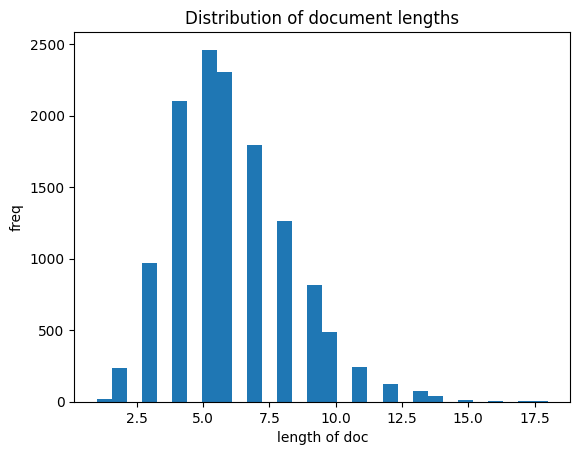

In [147]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of document lengths")
fig.show()

データを長さで濾過

In [148]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 15
11 cases removed due to max_doc_size
min doc size: 3
253 cases removed due to min_doc_size
264 cases removed in total


In [149]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
0    12700
Name: count, dtype: int64
sound
1    12700
Name: count, dtype: int64


In [150]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    11977
1      723
Name: count, dtype: int64
dutch
0    11621
1     1079
Name: count, dtype: int64
english
0    8559
1    4141
Name: count, dtype: int64
esperanto
0    11972
1      728
Name: count, dtype: int64
french
0    11700
1     1000
Name: count, dtype: int64
german
0    11911
1      789
Name: count, dtype: int64
icelandic
0    11764
1      936
Name: count, dtype: int64
japanese
0    11916
1      784
Name: count, dtype: int64
korean
0    11979
1      721
Name: count, dtype: int64
spanish
0    11772
1      928
Name: count, dtype: int64
swahili
0    11829
1      871
Name: count, dtype: int64


英語事例の割合補正

In [151]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
568,dɑɹk,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,4
2622,sʌn,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,3
986,hwaɪtlɑk,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,8
2739,teɪkɪŋ,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,6
394,deɪlaɪt,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,3
879,wiᵑgi,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
880,hasiɾa,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,6
881,maɗai,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5


In [152]:
## 結果の検査 3
for lang in selected_langs:
    print(raw_df[lang].value_counts().sort_index())

arabic
0    8664
1     723
Name: count, dtype: int64
dutch
0    8308
1    1079
Name: count, dtype: int64
english
0    8559
1     828
Name: count, dtype: int64
esperanto
0    8659
1     728
Name: count, dtype: int64
french
0    8387
1    1000
Name: count, dtype: int64
german
0    8598
1     789
Name: count, dtype: int64
icelandic
0    8451
1     936
Name: count, dtype: int64
japanese
0    8603
1     784
Name: count, dtype: int64
korean
0    8666
1     721
Name: count, dtype: int64
spanish
0    8459
1     928
Name: count, dtype: int64
swahili
0    8516
1     871
Name: count, dtype: int64


# 解析

In [153]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
main_df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [154]:
## ngram の追加

## module 探索範囲の拡張
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

# name the shared variable
bases = main_df[doc_type]
bases

739       eskina
333       siːðan
493        vifaa
482        ɔr̥ka
93      ɐlaɛçtɐn
          ...   
2824       tɜɹmz
584      enɛʁɡiː
685       sabakɯ
292        tasit
737       sɯkiɾɯ
Name: form, Length: 9387, dtype: object

In [155]:
## 1gram 列の追加

unigrams = bases.apply(lambda x: re.split(r"", x))

## remove null elements
unigrams = [ [ u for u in x if len(u) > 0 ] for x in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
main_df['1gram'] = unigrams
if verbose:
    main_df

In [156]:
## 2gram の作成

bigrams = ngrams.list_gen_bigrams(bases, sep = r"", check = False)
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
pp.pprint(random.sample(bigrams, 3))

## 2gram列の追加
main_df['2gram'] = bigrams
if verbose:
    main_df

[['vɪ', 'ɪn', 'nt', 'v', 'ɪ', 'n', 't'],
 ['aː', 'ːl', 'lr', 'ra', 'aq', 'qm', 'a', 'ː', 'l', 'r', 'a', 'q', 'm'],
 ['ɔr', 'r̥', '̥k', 'ka', 'ɔ', 'r', '̥', 'k', 'a']]


In [157]:
## 3gram の作成

trigrams = ngrams.list_gen3grams(bases, sep = r"", check = False)
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]
pp.pprint(random.sample(trigrams, 2))

## 3gram列の追加
main_df['3gram'] = trigrams
if verbose:
    main_df

[['zan', 'ant', 'za', 'an', 'nt', 'z', 'a', 'n', 't'],
 ['sap',
  'apɯ',
  'pɯɾ',
  'ɯɾa',
  'ɾai',
  'sa',
  'ap',
  'pɯ',
  'ɯɾ',
  'ɾa',
  'ai',
  's',
  'a',
  'p',
  'ɯ',
  'ɾ',
  'a',
  'i']]


In [158]:
## skippy 2grams の生成

import ngrams_skippy
skippy_2grams = [ ngrams_skippy.gen_skippy_bigrams(x, missing_mark = gap_mark,
                                                    max_distance = max_ga_val, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
pp.pprint(random.sample(skippy_2grams, 2))

## skippy 2gram 列の追加
main_df['skippy2gram'] = skippy_2grams
if verbose:
    main_df

[['ɸɯ',
  'ɸ…ɾ',
  'ɸ…o',
  'ɸ…ɴ',
  'ɸ…t',
  'ɯɾ',
  'ɯ…o',
  'ɯ…ɴ',
  'ɯ…t',
  'ɾo',
  'ɾ…ɴ',
  'ɾ…t',
  'ɾ…o',
  'oɴ',
  'o…t',
  'o…o',
  'ɴt',
  'ɴ…o',
  'to',
  'ɸ',
  'ɯ',
  'ɾ',
  'o',
  'ɴ',
  't',
  'o'],
 ['ve',
  'v…ʁ',
  'v…i',
  'v…f',
  'v…j',
  'v…a',
  'v…t',
  'eʁ',
  'e…i',
  'e…f',
  'e…j',
  'e…a',
  'e…t',
  'ʁi',
  'ʁ…f',
  'ʁ…j',
  'ʁ…a',
  'ʁ…t',
  'if',
  'i…j',
  'i…a',
  'i…t',
  'fj',
  'f…a',
  'f…t',
  'ja',
  'j…t',
  'at',
  'v',
  'e',
  'ʁ',
  'i',
  'f',
  'j',
  'a',
  't']]


In [159]:
## skippy 3grams の生成
import ngrams_skippy
skippy_3grams = [ ngrams_skippy.gen_skippy3grams(x, missing_mark = gap_mark,
                                                         max_distance = max_ga_val, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
pp.pprint(random.sample(skippy_3grams, 2))

## skippy 3gram 列の追加
main_df['skippy3gram'] = skippy_3grams
if verbose:
    main_df

[['pet',
  'pe…͡',
  'pe…s',
  'pe…o',
  'p…t͡',
  'p…t…s',
  'p…t…o',
  'p…͡s',
  'p…͡…o',
  'p…so',
  'et͡',
  'et…s',
  'et…o',
  'e…͡s',
  'e…͡…o',
  'e…so',
  't͡s',
  't͡…o',
  't…so',
  '͡so',
  'pe',
  'p…t',
  'p…͡',
  'p…s',
  'p…o',
  'et',
  'e…͡',
  'e…s',
  'e…o',
  't͡',
  't…s',
  't…o',
  '͡s',
  '͡…o',
  'so',
  'p',
  'e',
  't',
  '͡',
  's',
  'o'],
 ['kui',
  'ku…ᵐ',
  'ku…ɓ',
  'ku…a',
  'k…iᵐ',
  'k…i…ɓ',
  'k…i…a',
  'k…ᵐɓ',
  'k…ᵐ…a',
  'k…ɓa',
  'uiᵐ',
  'ui…ɓ',
  'ui…a',
  'u…ᵐɓ',
  'u…ᵐ…a',
  'u…ɓa',
  'iᵐɓ',
  'iᵐ…a',
  'i…ɓa',
  'ᵐɓa',
  'ku',
  'k…i',
  'k…ᵐ',
  'k…ɓ',
  'k…a',
  'ui',
  'u…ᵐ',
  'u…ɓ',
  'u…a',
  'iᵐ',
  'i…ɓ',
  'i…a',
  'ᵐɓ',
  'ᵐ…a',
  'ɓa',
  'k',
  'u',
  'i',
  'ᵐ',
  'ɓ',
  'a']]


DTM 構築

In [160]:
## LDA 構築の基になる document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary
bots = main_df[lda_term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<5958 unique tokens: ['a', 'e', 'es', 'e…a', 'e…i']...>


In [161]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 1
abuse filter: 0.003
Dictionary<4570 unique tokens: ['ð…n', 'aa', 'v…f', 'ɔ…̥', '̥k']...>


In [162]:
## Corpus (gensim の用語では corpus) の構築

corpus = [ diction.doc2bow(bot) for bot in bots ]

check = False
if check:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 9387


LDA モデルの構築

In [163]:
## LDA モデルの構築

from gensim.models import LdaModel as LDAmodel
print(f"Building LDA model with n_topics: {n_topics}")
doc_lda = LDAmodel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(doc_lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 15


LdaModel<num_terms=5958, num_topics=15, decay=0.5, chunksize=2000>


In [164]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15
0,a,u,a,ː,t,ʁ,r,ː,i,e,a,o,t,d,ɯ
1,ð,a,i,n,ɛ,ɔ,t,u,e,l,a…a,ɯ,s,a,b
2,r,k,o,ŋ,n,j,p,t,t,ɾ,i,t,n,ɪ,s
3,p,͡,p,ɪ,s,̃,a,a,s,s,m,i,ə,ə,ʰ
4,s,ʌ,n,k,v,e,x,l,n,e…e,l,m,ʁ,ɹ,̠
5,ɾ,t,k,l,ɛ…t,a,ɛ,o,a,ɹ,ː,o…o,ɛ,ʒ,ː
6,i,̹,g,ə,l,i,a…r,uː,u,f,k,k,k,r,a
7,ː,t͡,a…i,b,ɪ,s,s,s,l,p,a…i,a,ɔ,t,a̠
8,o,u…a,z,a,r,k,t…r,n,k,a…e,ma,i…o,ʃ,w,ɾ
9,h,ɕ,a…a,m,ʏ,ɔ̃,ɑ,aː,i…a,e…a,aː,s,ɑ,d…a,i


LDAvis の実行

In [165]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS  = False
LDAvis_use_tSNE  = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif LDAvis_use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [166]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()
if verbose:
    topic_dist

In [167]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[1.         1.0000001  1.         0.99999994 0.9999998  1.
 0.99999994 1.         1.         0.99999994 1.         1.
 1.         1.         1.        ]


In [168]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

15.000001


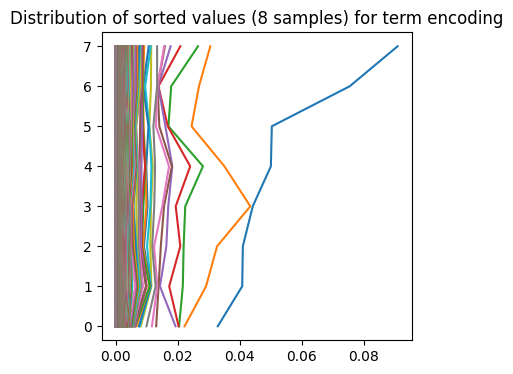

In [169]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,4))
df_size = len(topic_dist)
sampling_rate = 0.5
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for term encoding")
plt.show()

In [170]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE as tSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
ppl_val = round(len(topic_dist) * top_perplexity_reduct_rate)
top_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = top_tSNE_3d.fit_transform(np.array(topic_dist))

In [171]:
## Plotlyを使って tSNE の結果の可視化 (3D)

import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"t-SNE 3D map of LDA topics (#topics: {n_topics}; doc: {doc_attr}; term: {lda_term_type})"
fig.update_layout(autosize = False, width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [172]:
if check:
    main_df

In [173]:
## LDA モデルを使って doc をエンコード

print(f"get LDA encodings for documents")
check    = False
lda_encoding = [ ]
for i, row in main_df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    lda_encoding.append([ e[-1] for e in enc ])
#
pp.pprint(random.sample(lda_encoding, 2))
print(f"#documents processed: {len(lda_encoding)}")

get LDA encodings for documents


[[0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.0005512798,
  0.9282377,
  0.0005512798,
  0.0005512798,
  0.064595655,
  0.0005512798],
 [0.00027667615,
  0.00027667615,
  0.00027667615,
  0.00027667615,
  0.1980442,
  0.00027667615,
  0.00027667615,
  0.76750666,
  0.00027667615,
  0.00027667615,
  0.00027667615,
  0.00027667615,
  0.00027667615,
  0.00027667615,
  0.031129]]
#documents processed: 9387


In [174]:
## FastText を使ったエンコードの準備

from gensim.models import FastText

## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")
## emulate sentences by concatenating character 1-grams by whitespaces
ft_corpus = [ " ".join(x) for x in main_df[ft_term_type] ]
random.sample(ft_corpus, 3)


get FastText encodings for documents


['deg egy gys yst ste de eg gy ys st te d e g y s t e',
 'kwa wa̠ a̠n ̠nt nt͡ t͡ɕ ͡ɕʰ ɕʰa ʰa̠ a̠ɭ kw wa a̠ ̠n nt t͡ ͡ɕ ɕʰ ʰa a̠ ̠ɭ k w a ̠ n t ͡ ɕ ʰ a ̠ ɭ',
 'po̞ o̞t ̞tʰ tʰɯ po o̞ ̞t tʰ ʰɯ p o ̞ t ʰ ɯ']

In [175]:
## FastText を使ったエンコード
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
print(random.sample(ft_encoding, 1))
print(f"data size: {len(ft_encoding)}")

[array([-0.00067481, -0.00244063, -0.00027616, -0.00106373,  0.0027244 ,
        0.00070726,  0.00212546,  0.00208953,  0.00243707, -0.00053916,
        0.0009483 , -0.00152998, -0.00052619, -0.00154502, -0.00031679,
       -0.00031162, -0.00029888,  0.00101051,  0.00223512, -0.00281133,
       -0.00205182, -0.00340505,  0.00122445, -0.00147065, -0.00116478,
       -0.00046658,  0.00134569,  0.00072477,  0.00157375,  0.00024139],
      dtype=float32)]
data size: 9387


In [176]:
## doc_encoding の選択

if use_FastText:
    if use_LDA: ## LDA x FastText
        doc_encoding = [ np.concatenate([x, y], dtype = object) for x, y in zip(lda_encoding, ft_encoding) ]
    else: ## FastText only
        doc_encoding = ft_encoding
else: ## LDA only
    doc_encoding = lda_encoding
#
print(random.sample(doc_encoding, 1))
print(f"data size: {len(doc_encoding)}")

[array([0.0007604750571772456, 0.0007604750571772456,
       0.0007604750571772456, 0.0007604750571772456,
       0.0007604750571772456, 0.0007604750571772456,
       0.0007604750571772456, 0.0007604750571772456,
       0.0007604750571772456, 0.0007604750571772456,
       0.0007604750571772456, 0.9893532991409302, 0.0007604750571772456,
       0.0007604750571772456, 0.0007604750571772456,
       -0.0016164188273251057, -0.0002382848470006138,
       -0.001884596305899322, -0.0007701487629674375,
       0.0025273223873227835, 0.0012479706201702356,
       -0.0015880634309723973, 0.0002571411314420402,
       0.0022925608791410923, 0.0011330319102853537,
       -0.0001800196769181639, -0.0009885142790153623,
       -0.00034084817161783576, -0.002909177215769887,
       0.0007923715165816247, -0.0028862159233540297,
       -0.0014155774842947721, -0.0001529652945464477,
       -0.00011525792797328904, -0.0035989920143038034,
       -0.0031507443636655807, 0.0023563485592603683,
       3.9

In [177]:
## df にenc 列の追加
#df['enc'] = [ list(map(lambda x: x[1], y)) for y in doc_encoding ]
main_df['enc'] = doc_encoding
main_df['enc']

739     [0.0004728291532956064, 0.0004728291532956064,...
333     [0.664035975933075, 0.0004728510684799403, 0.0...
493     [0.0007607254083268344, 0.0007607254083268344,...
482     [0.0006604916416108608, 0.0006604916416108608,...
93      [0.00028037247830070555, 0.0002803724783007055...
                              ...                        
2824    [0.0008232839754782617, 0.0008232839754782617,...
584     [0.00036841872497461736, 0.0003684187249746173...
685     [0.0004963015089742839, 0.0004963015089742839,...
292     [0.000660090649034828, 0.000660090649034828, 0...
737     [0.00047285202890634537, 0.0004728520289063453...
Name: enc, Length: 9387, dtype: object

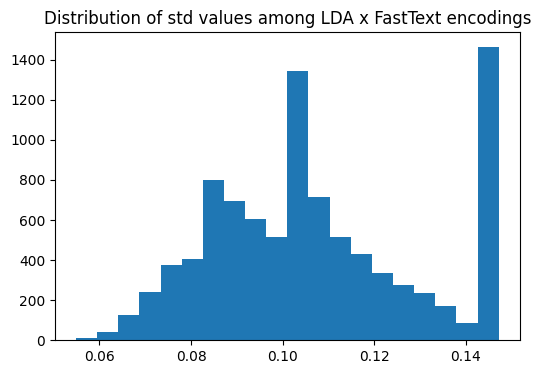

In [178]:
## 濾過前のエンコーディングのstd の分布を確認

import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))
plt.hist([ np.std(x) for x in main_df['enc'] ], bins = 20)
plt.title(f"Distribution of std values among {encoding_method} encodings")
plt.show()

In [179]:
## 一様分布の事例を除外

import numpy as np

check = False
doc_enc = main_df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

std 1st min: 0.05489456801351788
std 2nd min: 0.14715208028004295


In [180]:
## df_filtered の定義
import numpy as np

print(f"{len(main_df)} instances before filtering")

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 6 # 穏健な値を得るために 6で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in main_df['enc'] ]
df_filtered = main_df[ std_tested ]
print(f"Filtering leaves {len(df_filtered)} instances: ({len(main_df) - len(df_filtered)} instances removed)")

9387 instances before filtering
std_threshold: 0.02452534671334049
Filtering leaves 9387 instances: (0 instances removed)


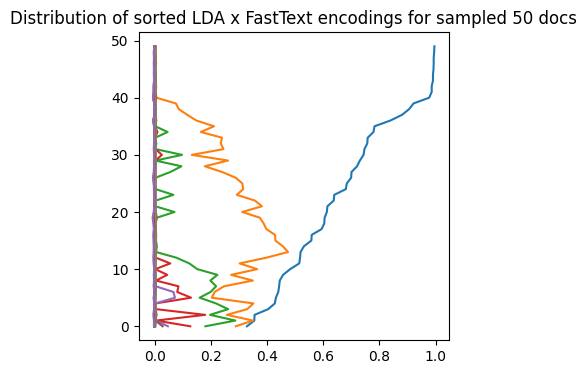

In [181]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted {encoding_method} encodings for sampled {sample_n} docs")
plt.show()

In [182]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic        723
dutch        1079
english       828
esperanto     728
french       1000
german        789
icelandic     936
japanese      784
korean        721
spanish       928
swahili       871
Name: count, dtype: int64

Dim Reduct 用の事例サンプリング

In [183]:
## Dim Reduct 用の事例サンプリング = doc_fit_df の定義
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 1877 rows after sampling


In [184]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'dutch', 'english',
       'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean',
       'spanish', 'swahili', 'language', 'family', 'size', '1gram', '2gram',
       '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

In [185]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
arabic       127
dutch        208
english      187
esperanto    148
french       179
german       172
icelandic    210
japanese     139
korean       132
spanish      197
swahili      178
Name: count, dtype: int64

In [186]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
arabic      127
english     187
germanic    590
japanese    139
korean      132
romance     524
swahili     178
Name: count, dtype: int64

UMAP を使った可視化 (3D)

In [187]:
## 必要に応じて
#!pip install -U ipywidgets

In [188]:
## UMAP を使った documents のグループ化

import numpy as np
import umap.umap_ as umap

## UMAP の生成
UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                    metric = umap_metric,
                    n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_UMAP_3d = UMAP_3d.fit_transform(doc_enc)

In [189]:
%%capture --no-display

## Plotlyを使って UMAP の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'
## umap_df を作成
X = zip(doc_UMAP_3d[:,0], doc_UMAP_3d[:,1], doc_UMAP_3d[:,2],
        doc_fit_df[colored_var], doc_fit_df[doc_type]) # zip(..)が必要
umap_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var, doc_type])
#
fig = go.Figure()
for lang_name in sorted(set(umap_df[colored_var])):
    # set marker size of the target domain
    traced = umap_df[ umap_df['language'] == lang_name ]
    fig.add_trace(
        go.Scatter3d(
            x = traced['D1'], y = traced['D2'], z = traced['D3'],
            name = lang_name.title(),
            mode = 'markers',
            marker = dict(size = 4, opacity = 0.8),
            marker_colorscale = color_palette, # worked??
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(umap_df)
## title_header
title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
## title_body
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

t-SNE の結果の可視化 (3D)

In [190]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
max_perplexity_factor = 3
perplexity_max_val = round(len(doc_fit_df)/max_perplexity_factor)
print(f"perplexity_max_val: {perplexity_max_val}")

divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
df_size = len(doc_fit_df)
exit_after_step = 3 # 15 is largest enough to complete the all steps
ppl_vals = enumerate(range(5, perplexity_max_val, perplexity_increment))
for step, ppl_val in ppl_vals:
    ## 早期終了の判定
    if step >= exit_after_step:
        continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val,
                          n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    ##
    X = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(main_df[colored_var]):
        traced = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = traced['D1'], y = traced['D2'], z = traced['D3'],
                name = lang.title(), mode = 'markers', marker = dict(size = 3),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_header = f"t-SNE 3D map (ppl: {ppl_val}) of {df_size} encodings for <{doc_attr}> via\n"
    if use_FastText:
        if use_LDA:
            title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
    title_val = title_header + title_body
    fig.update_layout(title = dict(text = title_val, font_size = 13),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 626
perplexity_increment: 125


In [191]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

t-SNE の結果の可視化 (2D)

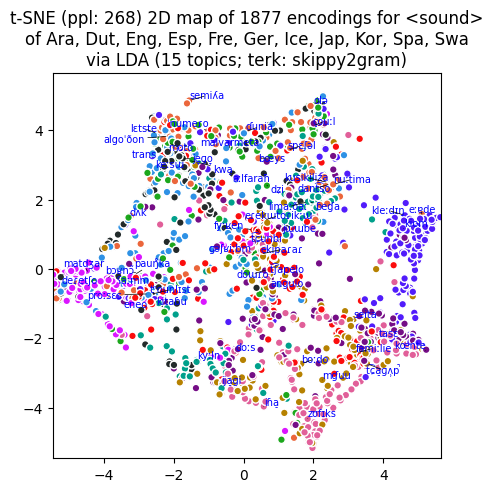

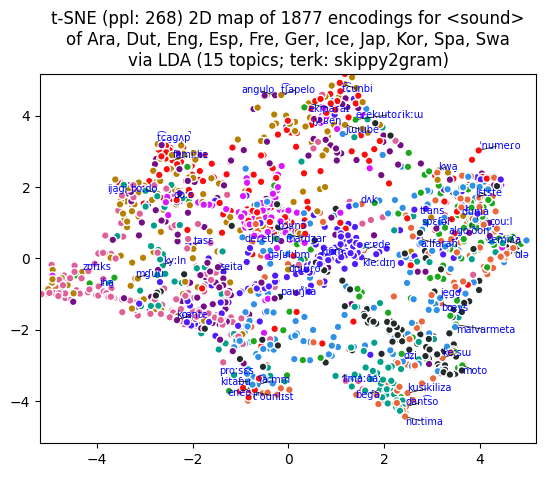

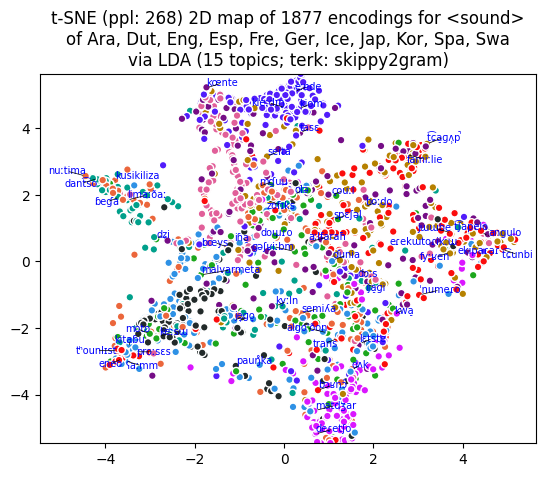

In [192]:
## tSNE の結果の可視化 (2D)

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
doc_perplexity_val = perplexity_selected
doc_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(doc_enc)

## plot_df の定義
X = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
plot_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
## 配色
plt.set_colors = pex.colors.qualitative.Plotly
## labeling
lab_sampling_rate = 0.03
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    
##
check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = plot_df.iloc[:, roll[0]], plot_df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in plot_df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 30, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    title_header = f"t-SNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} encodings for <{doc_attr}>\n"
    title_body = f"of {', '.join([ l.title() for l in sorted([ l[:3] for l in selected_langs])])}\n"
    title_tail = f"via LDA ({n_topics} topics; terk: {lda_term_type})"          
    plt.title(title_header + title_body + title_tail)
    #plt.legend(df['language'])
    plt.show()

DBSCAN を使ったクラスタリング

In [193]:
## DBSCAN を使ったクラスタリング

from sklearn.cluster import DBSCAN

DBSCAN_uses_UMAP = True
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps は事例ごとに調節が必要
min_samples_val = 2
## looking for optimal eps val compatible with color palette
max_n_clusters = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids = None
print(f"Looking for the optimal eps val...")
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
check = False
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
final result: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


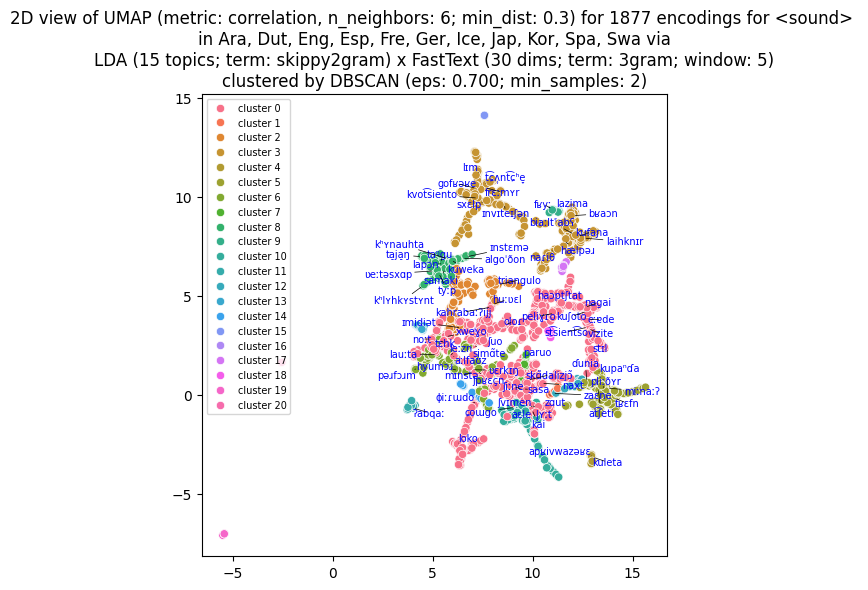

In [194]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
#
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in dbscan_clustered.labels_ ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.04 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(plot_df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
sampled_keys = [ x[:max_doc_size] for x in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_lang_list = f"{', '.join([ l.title() for l in [ l[:3] for l in selected_langs] ])}"
## title_header
df_size = len(plot_df)
if DBSCAN_uses_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} encodings for <{doc_attr}> \nin {used_lang_list} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} encodings for <{doc_attr}> in\n{used_lang_list} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBSCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

In [195]:
## co-clusteredness に基づく言語間類似度の計算

import pandas as pd
from sklearn.cluster import DBSCAN

#DBSCAN_uses_UMAP = True # tSNE は有効でないようだ
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2

## 精度を上げるために，クラスター数を多目にする
scaling_factor = 5
max_n_clusters_for_correl = round(len(selected_langs) * scaling_factor)
print(f"max_n_clusters_for_correl")

print(f"Looking for the optimal value for eps...")
check = False
x_dbscan_clustered = None
x_cluster_ids = None
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    x_dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    x_cluster_ids_local = x_dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(x_cluster_ids_local)}")
    try:
        assert len(np.unique(x_cluster_ids_local)) <= max_n_clusters_for_correl
        x_dbscan_clustered = x_dbscan_clustered_local
        x_cluster_ids = x_cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(x_cluster_ids)}")

## clusterごとに言語の帰属数を集計
selector_var = 'language'
bindings = zip(doc_fit_df[doc_type], doc_fit_df[selector_var], x_dbscan_clustered.labels_)
binding_df = pd.DataFrame(bindings, columns = ['form', selector_var, 'cluster'])

selector_names = sorted(set(binding_df[selector_var]))
print(f"selector_names: {selector_names}")

cluster_ids = sorted(set(binding_df['cluster']))
print(f"cluster ids: {cluster_ids}")

clusterwise_counts = { selector_name : None for selector_name in selector_names }
for selector_name in selector_names:
    counts = [ ]
    selected = binding_df[ binding_df[selector_var] == selector_name ]
    for i, cluster_id in enumerate(cluster_ids):
        matched = selected[ selected['cluster'] == cluster_id ]
        n_matches = len(matched)
        if n_matches == 0:
            counts.append(0)
        else:
            counts.append(int(n_matches))
    clusterwise_counts[selector_name] = counts

## クラスターでの生起個数の間の相関を計算
clusterwise_counts_df = pd.DataFrame.from_dict(clusterwise_counts) ## Truly versatile
clusterwise_counts_df

max_n_clusters_for_correl
Looking for the optimal value for eps...
final result: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
selector_names: ['arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']
cluster ids: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili
0,1,0,0,1,0,1,1,0,0,0,0
1,0,24,2,1,0,15,43,0,1,1,0
2,4,12,5,37,12,15,29,5,3,22,34
3,3,1,0,3,2,0,2,0,0,0,0
4,2,14,29,0,2,24,8,0,4,1,0
5,0,25,67,0,3,3,1,0,0,0,0
6,12,2,1,12,1,0,18,11,10,47,16
7,0,1,0,4,0,1,2,0,1,0,4
8,1,2,1,0,98,10,2,1,3,2,4
9,0,13,6,0,0,9,0,5,17,0,0


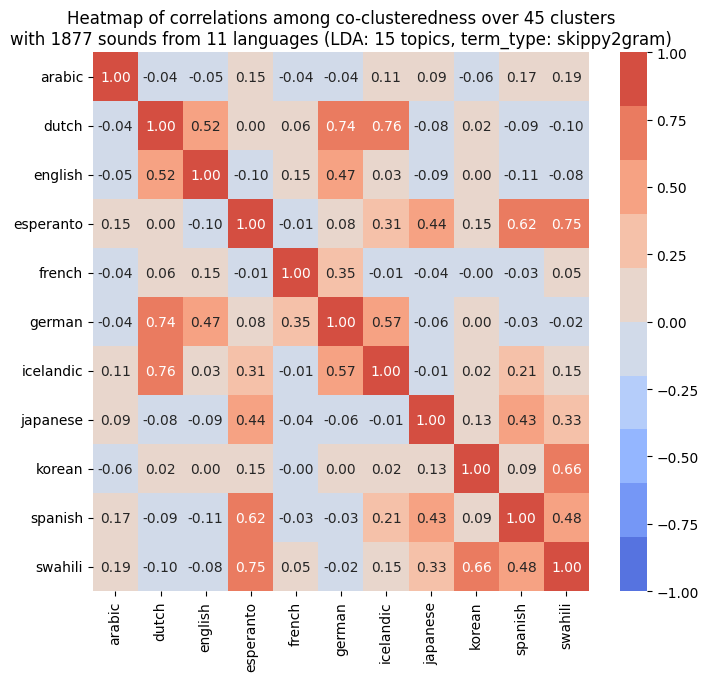

In [200]:
## Heatmap で可視化

import seaborn as sns

counts_df_normalized = (clusterwise_counts_df - clusterwise_counts_df.min())/(clusterwise_counts_df.max() - clusterwise_counts_df.min())
corr_df = counts_df_normalized.corr()
#corr_df.sort_index(axis = 0, inplace = True)
#corr_df.sort_index(axis = 1, inplace = True)

n_selectors = len(selector_names)
fig = plt.figure(figsize = (round(n_selectors * 0.7), round(n_selectors * 0.6)))
sns.heatmap(corr_df, cmap = sns.color_palette('coolwarm', 10),
            annot = True, fmt = '.2f', vmin = -1, vmax = 1)

title_val = f"Heatmap of correlations among co-clusteredness over {len(cluster_ids)} clusters\nwith {len(dbscan_source)} {doc_attr}s from {n_selectors} {selector_var}s (LDA: {n_topics} topics, term_type: {lda_term_type})"
plt.title(title_val)
plt.show()

階層クラスタリングのための部分サンプリングの追加

In [197]:
## 階層クラスタリングのための事例のサンプリング

df_size = len(doc_fit_df)
hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

188 rows are sampled


language
arabic       18
dutch        22
english      18
esperanto    17
french       28
german       13
icelandic    19
japanese     11
korean        8
spanish      22
swahili      12
Name: count, dtype: int64

階層クラスタリングの実行

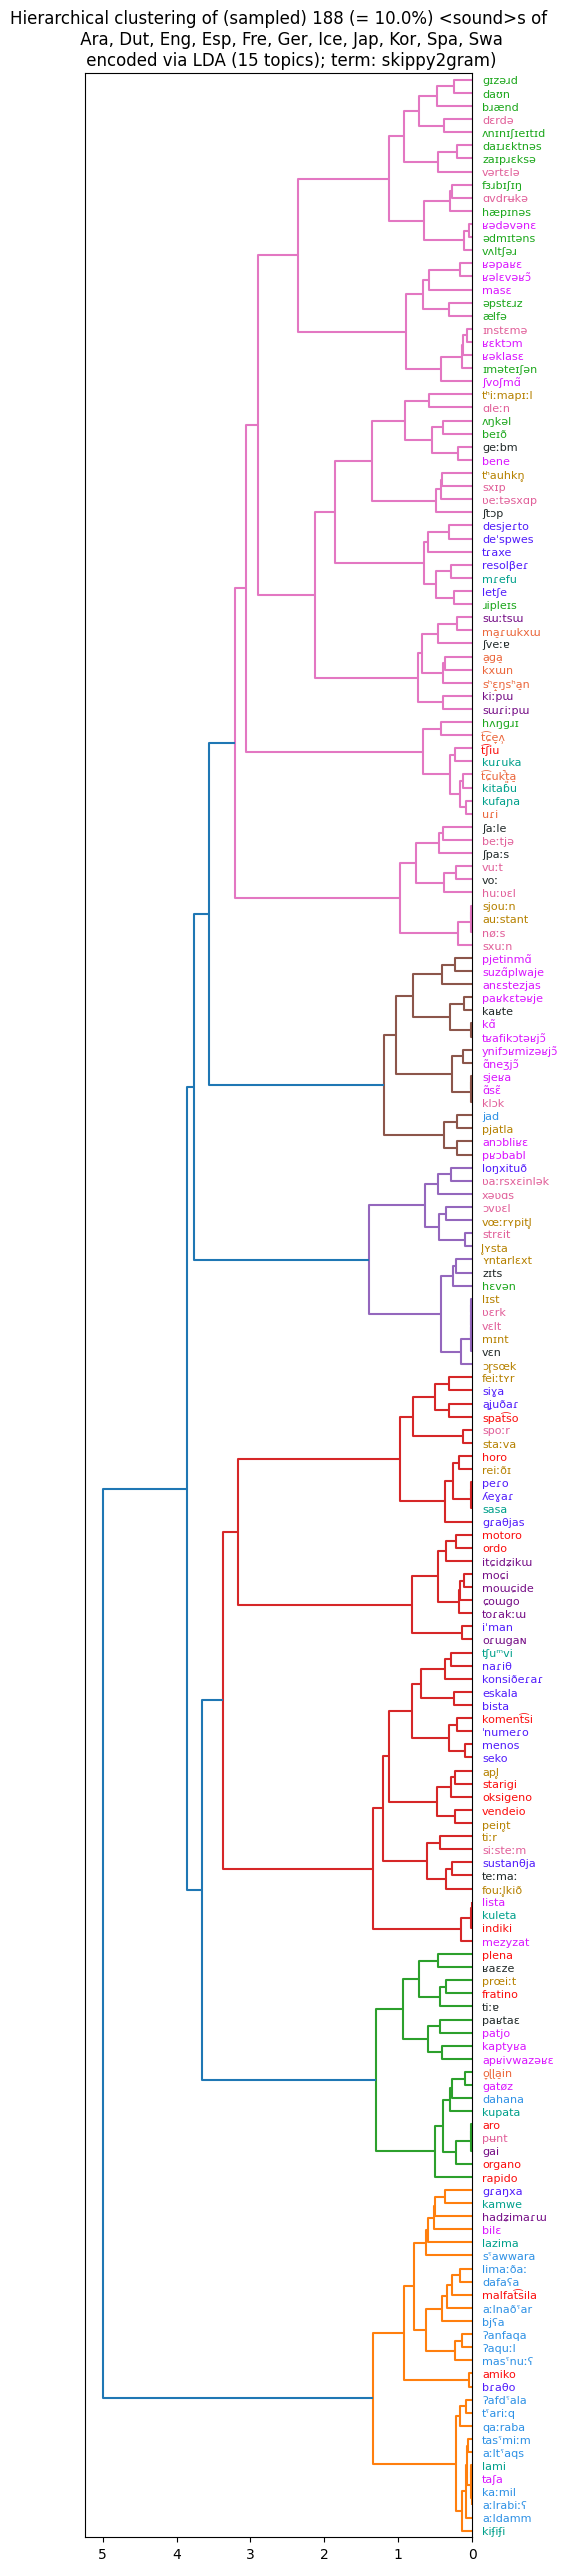

In [198]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) <{doc_attr}>s of\n \
    {', '.join([ l.title()[:3] for l in sorted(selected_langs)])}\n \
    encoded via LDA ({n_topics} topics); term: {lda_term_type})")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()
## A few Turkish words will be partially garbled.